In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Node.JS and React,184.144629,5.940149,10.577500,31
"Mexican Gothic, Moreno-Garcia",572.666626,20.452379,35.155638,28
Azure Functions Core Tools,442.100445,26.005909,39.897368,17
Node.js and Vite,1809.924240,44.144494,68.618651,41
Django,1786.416184,44.660405,64.712311,40
Azure Files Documentation,3400.062022,56.667700,151.921187,60
VMWare,57.013086,57.013086,57.013086,1
Python,4849.595508,57.733280,222.184284,84
Active Directory and Azure Files,2377.928358,64.268334,108.605676,37
CCH Tax Forms Project,1352.120120,64.386672,138.056034,21


# Histogram

sum of ages: ~51030.00


<Axes: >

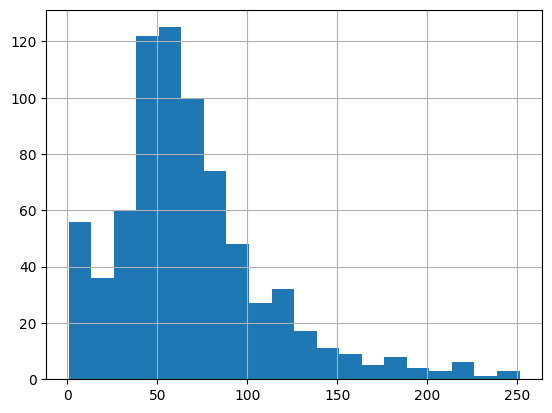

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~51030.00


<Axes: >

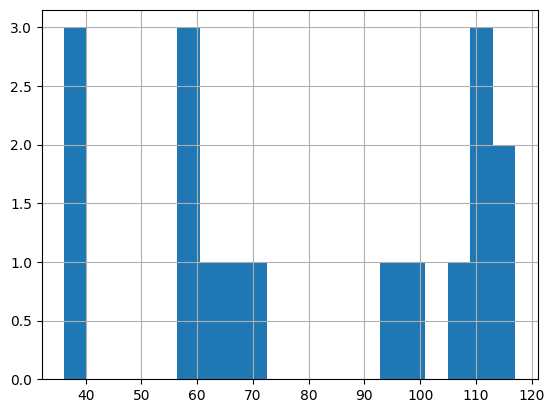

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Asynchronous Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
n = 3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 747
Total card age: 51030.00


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
20,Python,Q:\nWhat method do you call to parse the comma...,58c3e5284b8e017e25b1fe16b13cb52b,-222.184284,57.73328,222.184284,-4849.595508,0.653994,84,0,0
21,Python,Q:\nWhat is the purpose of @functools.wraps in...,9444aaaa698dbda1d279cdb6b2e93ea5,-152.043389,57.73328,222.184284,-4849.595508,0.653994,84,3,0
22,Python,from functools import wraps\n\ndef type_check(...,30f1b26b80ccbd7d02a63021180eebf7,-135.209606,57.73328,222.184284,-4849.595508,0.653994,84,6,0
568,Python,Q:\nWhat keyword is used to define an asynchro...,cdb48c8b8bfb165bc04d89a73a5d8df1,-116.192427,57.73328,222.184284,-4849.595508,0.653994,84,9,0
24,Python,Q:\nHow do you iterate over an asynchronous ge...,aef564477e4f1aa92f0bfd7799bd1b5c,-105.307957,57.73328,222.184284,-4849.595508,0.653994,84,12,0
569,Python,Display a postfix message that updates with th...,bdcabe2c4d99e9ff772d9cd4e8cece18,-96.669496,57.73328,222.184284,-4849.595508,0.653994,84,15,0
571,Python,"Q:\nWhat is lazy evaluation, and how do genera...",2916065a4a1c2389fc0c4062909198ca,-81.298786,57.73328,222.184284,-4849.595508,0.653994,84,18,0
26,Python,Q:\nHow can you modify the Python path at runt...,6f2bc79611835afce9d459a2a4b01b32,-76.846544,57.73328,222.184284,-4849.595508,0.653994,84,21,0
305,Python,Q:\nWhich Python module provides an object-ori...,e0f21808be1ac9152eaecf47c5a28d93,-73.661859,57.73328,222.184284,-4849.595508,0.653994,84,24,0
29,Python,Q:\nWhat is the difference between yield and r...,d1fa8e22f2c6ba55b2f392d511b3452d,-72.656016,57.73328,222.184284,-4849.595508,0.653994,84,27,0


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(-1132.0703650945015)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
81,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,-251.454504,90.378744,251.454504,-4247.800991,0.395009,47,0,0
97,PnP PowerShell,App-Only Authentication\nA mode where applicat...,12d9bc97a1e6f53d3b7295eb85274bad,-246.383545,98.896828,246.383545,-3362.492139,0.845985,34,0,0
129,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,-240.068271,87.947565,240.068271,-2814.322082,0.541282,32,0,0
358,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,-230.525634,90.378744,251.454504,-4247.800991,0.395009,47,1,1
20,Python,Q:\nWhat method do you call to parse the comma...,58c3e5284b8e017e25b1fe16b13cb52b,-222.184284,57.733280,222.184284,-4849.595508,0.653994,84,0,0
374,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,-222.018049,98.896828,246.383545,-3362.492139,0.845985,34,1,1
171,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,-220.412812,99.137123,220.412812,-1784.468206,0.694963,18,0,0
640,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,-217.640486,98.896828,246.383545,-3362.492139,0.845985,34,2,2
64,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,-215.552273,89.349224,215.552273,-4467.461211,0.916688,50,0,0
153,Vocab,Anacoluthon\nnoun\nSPA: an-uh-koh-LOO-thon\nIP...,58fe2f5c535300af7c826eb1cff7d208,-214.771129,91.440615,214.771129,-2286.015368,0.506173,25,0,0


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.313'